# 🏋️‍♂️ Clasificación de Noticias con Embeddings y LSTMs

## El Objetivo

Nuestro objetivo es construir y entrenar un modelo de Deep Learning capaz de clasificar titulares de noticias en una de cuatro categorías predefinidas. Para ello, usaremos el dataset **AG News**.

## El Dataset: AG News

A diferencia del conocido dataset de reviews de películas de IMDB, AG News nos presenta un reto de **clasificación multiclase**. Los titulares pertenecen a una de las siguientes 4 categorías:

1.  **World (Mundo)**
2.  **Sports (Deportes)**
3.  **Business (Negocios)**
4.  **Sci/Tech (Ciencia/Tecnología)**

A lo largo de este notebook, seguirás los siguientes pasos:

1.  **Carga de Datos**: Cargaremos el dataset usando la librería `tensorflow_datasets`.
2.  **Preprocesamiento**: Prepararemos el texto para que nuestro modelo pueda entenderlo (Tokenización, Padding).
3.  **Construcción del Modelo**: Diseñaremos una red neuronal con una capa de `Embedding` y una capa `LSTM`.
4.  **Entrenamiento**: Entrenaremos el modelo con nuestros datos, usando callbacks para optimizar el proceso.
5.  **Evaluación**: Mediremos qué tan bueno es nuestro modelo usando métricas adecuadas y visualizaciones.



## 0. Importación de Librerías

Primero, importemos todas las herramientas que necesitaremos en nuestro taller.

In [3]:
# !pip install tensorflow-datasets

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow y Keras
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn para el split y la evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## 1. Carga del Dataset

Usaremos `tensorflow_datasets` para cargar el dataset `ag_news_subset`. Esta es una forma muy cómoda y estandarizada de acceder a datasets públicos.

El objeto `ds` que cargamos es un `tf.data.Dataset`, que es muy eficiente pero necesita ser convertido a un formato más manejable como listas de Python para nuestro preprocesamiento con Scikit-learn y Keras.

In [5]:
# Cargar el dataset
ds, ds_info = tfds.load('ag_news_subset', with_info=True, as_supervised=True)
ds_train = ds['train']
ds_test = ds['test'] # Ojo, este es el test set oficial. Nosotros crearemos nuestro propio split.

# Info del dataset
print(ds_info.features)
print(f"Nombre de las clases: {ds_info.features['label'].names}")
print(f"Número de clases: {ds_info.features['label'].num_classes}")


c:\Users\Ort\miniconda3\envs\data_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:17<00:00, 17.27s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:17<00:00, 17.60s/ url]


Dataset ag_news_subset downloaded and prepared to C:\Users\Ort\tensorflow_datasets\ag_news_subset\1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'description': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=4),
    'title': Text(shape=(), dtype=string),
})
Nombre de las clases: ['World', 'Sports', 'Business', 'Sci/Tech']
Número de clases: 4


### ✍️ **Tu Tarea (1/7): Extraer Datos a Listas**

Ahora, itera sobre el `tf.data.Dataset` (`ds_train`) y extrae las descripciones (texto) y las etiquetas (labels) a dos listas de Python: `sentences` y `labels`.

**Pista:** Los datos vienen en tensores de TensorFlow. Puede que necesites usar `.numpy()` para convertirlos a valores de NumPy/Python.

In [ ]:
sentences = []
labels = []

### TU CÓDIGO AQUÍ ###
# Itera sobre el dataset ds_train.
# En cada iteración, obtienes un (texto, etiqueta).
# Añade el texto (decodificado a utf-8) a la lista 'sentences'.
# Añade la etiqueta a la lista 'labels'.






### FIN DE TU CÓDIGO ###

# Convertimos las listas a arrays de numpy para mayor eficiencia
labels = np.array(labels)

print(f"Total de frases: {len(sentences)}")
print(f"Total de etiquetas: {len(labels)}")
print("\nEjemplo de frase:")
print(sentences[0])
print(f"Etiqueta correspondiente: {labels[0]} ({ds_info.features['label'].names[labels[0]]}) ")

Total de frases: 120000
Total de etiquetas: 120000

Ejemplo de frase:
AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
Etiqueta correspondiente: 3 (Sci/Tech) 


## 2. Preprocesamiento de los Datos

¡Genial! Ahora que tenemos los datos en un formato manejable, es hora de prepararlos para la red neuronal. Este es uno de los pasos más importantes en cualquier proyecto de NLP.

### ✍️ **Tu Tarea (2/7): División en Train y Validation**

Antes de hacer nada, debemos separar nuestros datos en un conjunto de entrenamiento y uno de validación. Usaremos `train_test_split` de Scikit-learn.

**Pista:** Es una buena práctica usar el parámetro `stratify` en problemas de clasificación para asegurar que la proporción de clases sea la misma en ambos conjuntos.

In [ ]:
### TU CÓDIGO AQUÍ ###
# Usa train_test_split para dividir 'sentences' y 'labels'.
# Usa un 20% de los datos para validación (test_size=0.2).
# Fija un random_state para que los resultados sean reproducibles (ej. random_state=42).
# ¡No te olvides de estratificar por las etiquetas!





### FIN DE TU CÓDIGO ###

print(f"Frases de entrenamiento: {len(train_sentences)}")
print(f"Frases de validación: {len(val_sentences)}")

Frases de entrenamiento: 96000
Frases de validación: 24000


### ✍️ **Tu Tarea (3/7): Tokenización**

Las redes neuronales no entienden de palabras, solo de números. La **tokenización** es el proceso de convertir texto en secuencias de números (tokens).

Usaremos el `Tokenizer` de Keras. Recuerda una regla de oro: **el `Tokenizer` se "entrena" (se ajusta) ÚNICAMENTE con los datos de entrenamiento** para evitar fuga de datos (data leakage).

**Pista:** El proceso es:
1.  Crear el `Tokenizer` (puedes limitar el número de palabras con `num_words`).
2.  Ajustarlo con `fit_on_texts()` usando los datos de `train`.
3.  Convertir los textos de `train` y `validation` a secuencias numéricas con `texts_to_sequences()`.

In [ ]:
# Hiperparámetros para el preprocesamiento
vocab_size = 10000  # Tamaño del vocabulario (palabras más comunes)
oov_tok = "<OOV>"    # Token para palabras fuera del vocabulario

### TU CÓDIGO AQUÍ ###


# 1. Crea una instancia de Tokenizer

# 2. Ajústalo SOLO con las frases de entrenamiento

# Obtenemos el índice de palabras (word_index)

# 3. Convierte las frases de entrenamiento y validación en secuencias




### FIN DE TU CÓDIGO ###

print(f"Tamaño del vocabulario encontrado: {len(word_index)}")
print("\nEjemplo de frase original:")
print(train_sentences[1])
print("\nSu correspondiente secuencia tokenizada:")
print(train_sequences[1])

Tamaño del vocabulario encontrado: 58637

Ejemplo de frase original:
University of California regents yesterday resoundingly rejected a proposal that sought to add a  quot;multiracial quot; category to UC #39;s admissions application.

Su correspondiente secuencia tokenizada:
[519, 5, 562, 1, 62, 1, 1223, 3, 1356, 12, 1741, 4, 1797, 3, 37, 1, 37, 6072, 4, 1, 10, 11, 1, 1171]


### ✍️ **Tu Tarea (4/7): Padding**

Nuestras secuencias tienen longitudes diferentes. Para que la red neuronal pueda procesarlas en lotes (batches), todas deben tener la misma longitud. A este proceso se le llama **padding**.

**Pista:** Usa la función `pad_sequences` de Keras. Tendrás que decidir una longitud máxima (`maxlen`). Una buena práctica es analizar la distribución de longitudes de tus secuencias. También debes decidir si el padding se añade antes (`pre`) o después (`post`) de la secuencia.

In [ ]:
# Hiperparámetros para el padding
max_length = 50     # Longitud máxima de las secuencias
trunc_type = 'post' # Truncar al final si la secuencia es más larga
padding_type = 'post'# Rellenar al final si la secuencia es más corta

### TU CÓDIGO AQUÍ ###


# Aplica padding a las secuencias de entrenamiento



# Aplica padding a las secuencias de validación


### FIN DE TU CÓDIGO ###

print("\nForma (shape) de los datos de entrenamiento con padding:")
print(train_padded.shape)
print("\nForma (shape) de los datos de validación con padding:")
print(val_padded.shape)
print("\nEjemplo de secuencia con padding:")
print(train_padded[1])


Forma (shape) de los datos de entrenamiento con padding:
(96000, 50)

Forma (shape) de los datos de validación con padding:
(24000, 50)

Ejemplo de secuencia con padding:
[ 519    5  562    1   62    1 1223    3 1356   12 1741    4 1797    3
   37    1   37 6072    4    1   10   11    1 1171    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## 3. Construcción del Modelo con Embedding y LSTM

¡Datos listos! Es el momento de la verdad: construir nuestra arquitectura de red neuronal.

### ✍️ **Tu Tarea (5/7): Definir la Arquitectura**

Crea un modelo secuencial en Keras con las siguientes capas:

1.  **Capa `Embedding`**: Será la primera capa. Es la que convierte los índices de palabras en vectores densos y aprende las relaciones entre palabras.
    -   `input_dim`: El tamaño de nuestro vocabulario.
    -   `output_dim`: La dimensionalidad del vector de embedding (un hiperparámetro a elegir).
    -   `input_length`: La longitud de nuestras secuencias ya "paddeadas".

2.  **Capa `Bidirectional(LSTM)`**: Usaremos una LSTM Bidireccional, que lee la secuencia en ambos sentidos (de izquierda a derecha y de derecha a izquierda), lo que suele dar mejores resultados en tareas de NLP.
    -   `units`: El número de neuronas en la LSTM (otro hiperparámetro).

3.  **Capa `Dense`**: Una capa oculta fully-connected con activación `relu` para añadir más capacidad de aprendizaje.

4.  **Capa `Dense` de Salida**: La capa final. Debe tener tantas neuronas como clases tengamos y usar la función de activación adecuada para clasificación multiclase.
    -   `units`: Número de clases.
    -   `activation`: Para clasificación multiclase, `softmax` es la elección correcta.

**Pista:** Puedes añadir capas de `Dropout` entre las capas `LSTM` y `Dense` para reducir el overfitting.

In [ ]:
# Hiperparámetros del modelo
embedding_dim = 64
lstm_units = 64
dense_units = 64
num_classes = ds_info.features['label'].num_classes

### TU CÓDIGO AQUÍ ###
model = Sequential([
    # 1. Capa Embedding
    
    # 2. Capa Bidirectional LSTM
    
    # 3. Capa Densa oculta
    
    # 4. Capa Densa de salida

    
])
### FIN DE TU CÓDIGO ###

# Imprimimos un resumen del modelo para ver la arquitectura
model.summary()

c:\Users\Ort\miniconda3\envs\data_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Compilación y Entrenamiento

Con el modelo definido, necesitamos compilarlo y luego, ¡entrenarlo!

### ✍️ **Tu Tarea (6/7): Compilar y Entrenar**

**Parte A: Compilación**
Usa `model.compile()`. Necesitas definir:
-   `loss`: La función de pérdida. Como nuestras etiquetas son números enteros (0, 1, 2, 3), `sparse_categorical_crossentropy` es la más eficiente.
-   `optimizer`: El algoritmo para actualizar los pesos del modelo. `adam` es una elección robusta y muy popular.
-   `metrics`: Las métricas para monitorizar. `accuracy` es fundamental.

**Parte B: Callback de EarlyStopping**
Para evitar el sobreajuste (overfitting) y no entrenar de más, crearemos un callback `EarlyStopping` que detendrá el entrenamiento si la `val_loss` (pérdida en validación) no mejora tras un número de épocas (`patience`).

**Parte C: Entrenamiento**
Usa `model.fit()` para lanzar el entrenamiento. Pasa los datos de entrenamiento, los de validación y el callback que has creado.

In [ ]:
### TU CÓDIGO AQUÍ ###
# Parte A: Compilación




# Parte B: Callback


# Hiperparámetros de entrenamiento





# Parte C: Entrenamiento






### FIN DE TU CÓDIGO ###

750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.9176 - loss: 0.2643 - val_accuracy: 0.9050 - val_loss: 0.2799


## 5. Evaluación del Modelo

¡Entrenamiento completo! Pero... ¿qué tal lo ha hecho nuestro modelo? Una simple métrica de `accuracy` no siempre cuenta toda la historia. Vamos a profundizar.

### ✍️ **Tu Tarea (7/7): Visualizar y Evaluar**

**Parte A: Gráficas de Entrenamiento**
Visualiza la `accuracy` y la `loss` del entrenamiento y la validación a lo largo de las épocas. Esto nos da una idea clara de si ha habido overfitting.

**Parte B: Métricas de Clasificación**
1.  Obtén las predicciones del modelo sobre el conjunto de validación (`val_padded`).
2.  Como la salida del modelo son probabilidades (por `softmax`), convierte estas probabilidades a la clase predicha (el índice con la probabilidad más alta) usando `np.argmax()`.
3.  Genera y muestra:
    -   Un **Reporte de Clasificación** (`classification_report`) para ver la precisión, recall y f1-score por cada clase.
    -   Una **Matriz de Confusión** (`confusion_matrix`) para ver qué clases se confunden más entre sí.

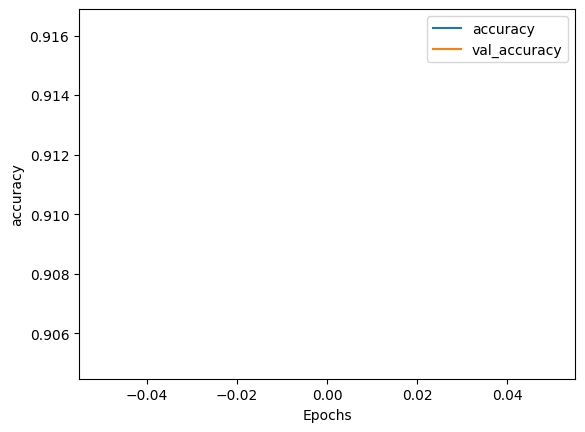

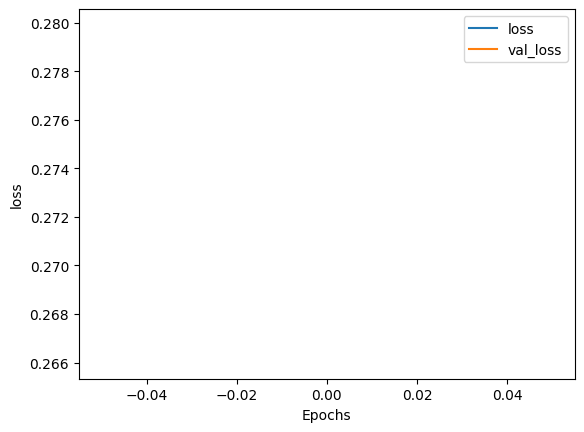

750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       World       0.92      0.88      0.90      6000
      Sports       0.95      0.97      0.96      6000
    Business       0.90      0.86      0.88      6000
    Sci/Tech       0.85      0.91      0.88      6000

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000


--- Matriz de Confusión ---


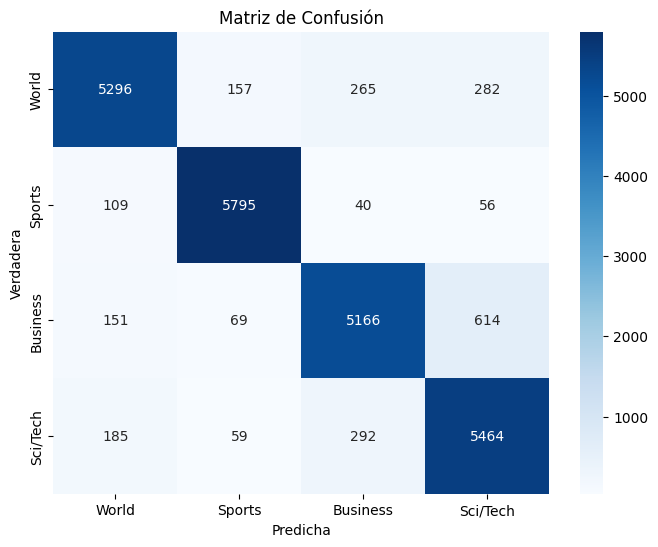

In [ ]:
# Parte A: Gráficas de Entrenamiento
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### TU CÓDIGO AQUÍ ###
# Parte B: Métricas de Clasificación

# 1. Obtener predicciones (probabilidades)


# 2. Convertir probabilidades a clases predichas (argmax)


# 3. Generar reporte y matriz de confusión





### FIN DE TU CÓDIGO ###

## 6. ¡A Jugar! Probando con tus Propias Frases

La parte más divertida. Vamos a ver cómo nuestro modelo clasifica frases nuevas que nunca ha visto.

El proceso es el mismo que para los datos de entrenamiento:
1. Poner la frase en una lista.
2. Tokenizarla.
3. Paddearla.
4. Predecirla.
5. Interpretar el resultado.

In [17]:
def predict_news(sentence):
    # Preprocesar la frase
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    # Predecir
    prediction_proba = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction_proba)
    
    # Obtener el nombre de la clase
    class_name = class_names[predicted_class_index]
    confidence = prediction_proba[0][predicted_class_index]
    
    print(f'Frase: "{sentence}"')
    print(f'Categoría Predicha: {class_name}')
    print(f'Confianza: {confidence:.2%}\n')

# Frases de ejemplo
predict_news("NASA launches new mission to explore Martian poles")
predict_news("Real Madrid signs new striker for the next season")
predict_news("Global markets react to the new interest rate policies")
predict_news("International summit discusses climate change and global politics")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Frase: "NASA launches new mission to explore Martian poles"
Categoría Predicha: Sci/Tech
Confianza: 99.13%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Frase: "Real Madrid signs new striker for the next season"
Categoría Predicha: Sports
Confianza: 96.76%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Frase: "Global markets react to the new interest rate policies"
Categoría Predicha: Sci/Tech
Confianza: 42.21%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Frase: "International summit discusses climate change and global politics"
Categoría Predicha: Sci/Tech
Confianza: 88.37%



## 🎓 Conclusión y Próximos Pasos

¡Enhorabuena! Has completado todo el flujo de trabajo para un problema de clasificación de texto usando Embeddings y LSTMs.

**Has aprendido a:**
- Cargar y preparar un dataset de texto.
- Tokenizar y paddear secuencias de texto de forma correcta.
- Construir un modelo de Keras con capas `Embedding` y `LSTM`.
- Entrenar el modelo eficientemente usando callbacks.
- Evaluar el rendimiento del modelo más allá de la simple accuracy.
- Usar el modelo entrenado para hacer predicciones sobre datos nuevos.

### Posibles Mejoras (Ideas para experimentar):

* **Ajuste de Hiperparámetros**: ¿Qué pasa si cambias el `embedding_dim`, `lstm_units` o el `vocab_size`?
* **Arquitectura del Modelo**: Prueba a apilar más capas LSTM (`return_sequences=True` en la primera) o a usar capas `GRU` en lugar de `LSTM`.
* **Embeddings Pre-entrenados**: En lugar de aprender los embeddings desde cero, podrías cargar embeddings pre-entrenados como GloVe o Word2Vec. Esto puede dar un gran impulso al rendimiento, especialmente con datasets más pequeños.

## TIME SERIES

https://www.kaggle.com/code/hassanamin/time-series-analysis-using-lstm-keras